# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [54]:
import twitter
import time 
import pandas as pd
import nltk
import unicodedata
import re

from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import DictVectorizer

CONSUMER_KEY = "hePd3DDRaupkFQngsxKtjBRZz"
CONSUMER_SECRET = "EOtAr6LteiptnZXDjJihirKFFYSnb3wass4sP0x1huCu37jyGD"

ACCESS_TOKEN_KEY = "854184242-VgURvPeNZjpplMwY5t1kRwAk2BVVTrOFngJt5nMZ"
ACCESS_TOKEN_SECRET = "TmE6pxGlufe5ZdybnDOZlZWplnsWDI2TmA1qSZo1e5awc"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [55]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

df_users.head()

#all was implementes for just 100 users, because I really had no time
#df_users = df_users[:100]

In [58]:
def get_user_tweets(user_id):
    
    tweets = api.GetUserTimeline(user_id, count = 100)
    
    res = [x.AsDict() for x in tweets]
    
    return res

one_try = get_user_tweets (202388889)




## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [59]:
def get_words(text):
    """returns list of words"""
    
    tmp = ''.join(c for c in unicodedata.normalize('NFD', text.lower()) if not unicodedata.combining(c))
    
    delete = re.compile(u'\W+?', re.UNICODE)
    
    return delete.sub(' ', tmp).split()

get_words(u"Where is my mind")

[u'where', u'is', u'my', u'mind']

In [60]:
print get_words(u"Here are different words!")

[u'here', u'are', u'different', u'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [6]:
import nltk
#nltk.download()

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [61]:
def get_tokens(words):
    
    wnl = WordNetLemmatizer()
    tmp = [wnl.lemmatize(i) for i in words]
    stopwords = nltk.corpus.stopwords.words('english')
    return [i for i in tmp if not i in stopwords]
    

[u'dog', u'brotherhood']

In [62]:
print get_tokens([u"here", u"are", u"different", u"words"])

[u'different', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [63]:
def get_tweet_tokens(tweet):
    
    tmp = get_words(tweet[u'text'])
    
    return get_tokens(tmp)


Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [66]:
import json
def collect_users_tokens(df_users):
    tweets = []
    for num, i in enumerate(df_users['uid']):
        
        try:
            tweets.append(get_user_tweets(i))
        except twitter.error.TwitterError:
            print "not found"
            continue
        except:
            print "waiting"
            time.sleep(900)
            continue
    
    usr_tokens = []
    for i, user in enumerate(tweets):
        usr_tokens.append(dict())
        for tweet in user:
            tokens = get_tweet_tokens(tweet)
            for tk in tokens:
                if tk in usr_tokens[i]:
                    usr_tokens[i][tk] += 1
                else:
                    usr_tokens[i][tk] = 1
    
    return df_users['uid'], usr_tokens

In [67]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer

users, users_tokens = collect_users_tokens(df_users)


not found


NameError: name 'usr_tokens' is not defined

In [68]:
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

Сохраним полученные данные в файл. Используется метод savez из numpy. 

In [69]:
import numpy as np
np.savez("files/out_4.dat", data = vs, users = users, users_tokens = users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

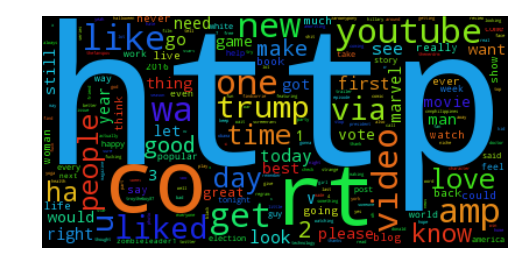

In [71]:
from wordcloud import WordCloud
import matplotlib.pylab as plt

def draw_tag_cloud(v, vs):
    
    name_list = v.get_feature_names()
    freqs_list = [np.sum(vs[:, i]) for i in xrange(len(name_list))]
    
    wcl = WordCloud()
    cloud = wcl.generate_from_frequencies([(w, freq) for w, freq in zip(name_list, freqs_list)])
    plt.imshow(cloud)
    plt.axis("off")
    plt.show()
    return

draw_tag_cloud(v, vs)
